In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from transformers import BertTokenizer
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
%matplotlib inline


from tensorflow.keras.optimizers import SGD
df = pd.read_csv("/Users/revglue/study/main_work/my_working/my_data_set/my_data_set.csv")
df.head(5)

,Annotator,Paper,Cited-by,Follow-up,Citing Sentence,Tagged Sentence
0,A,A00-1043,C00-2140,0,Since we only use shallow methods for textual ...,Since we only use shallow methods for textual ...
1,A,A00-1043,P02-1057,0,Sentence simplification systems (Chandrasekar ...,Sentence simplification systems (GTREF) are ca...
2,A,A97-1011,W09-1118,1,Each token is represented using a fairly stand...,Each token is represented using a fairly stand...
3,A,A97-1011,A00-2017,1,The training and the test data were processed ...,The training and the test data were processed ...
4,A,A97-1011,C00-2099,0,The only other high- delity computational rend...,The only other high-_x005f delity computationa...


In [2]:
df['Citation Type']=df['Follow-up'].apply(lambda x: 'Related work' if x==0 else ('Comparison' if x==1 else ('Using the work' if x==2 else 'Extending the work')))

In [3]:
import math

def softmax(z):
    z_exp = [math.exp(i) for i in z]
    sum_z_exp = sum(z_exp)
    return [i / sum_z_exp for i in z_exp]

In [4]:
df['Coarse Label']=df['Follow-up'].apply(lambda x: 'Incidental' if x==0 or x==1 else 'Important')
df['normalized']=softmax(df['Follow-up'])

df.head(15)

,Annotator,Paper,Cited-by,Follow-up,Citing Sentence,Tagged Sentence,Citation Type,Coarse Label,normalized
0,A,A00-1043,C00-2140,0,Since we only use shallow methods for textual ...,Since we only use shallow methods for textual ...,Related work,Incidental,0.000508
1,A,A00-1043,P02-1057,0,Sentence simplification systems (Chandrasekar ...,Sentence simplification systems (GTREF) are ca...,Related work,Incidental,0.000508
2,A,A97-1011,W09-1118,1,Each token is represented using a fairly stand...,Each token is represented using a fairly stand...,Comparison,Incidental,0.001380
3,A,A97-1011,A00-2017,1,The training and the test data were processed ...,The training and the test data were processed ...,Comparison,Incidental,0.001380
4,A,A97-1011,C00-2099,0,The only other high- delity computational rend...,The only other high-_x005f delity computationa...,Related work,Incidental,0.000508
5,A,A97-1011,W04-1505,0,The Statistical Dependency Model Most successf...,The Statistical Dependency Model Most successf...,Related work,Incidental,0.000508
6,A,A97-1011,P99-1033,0,J~irvinen and Tapananinen have demonstrated an...,J~irvinen and Tapananinen have demonstrated an...,Related work,Incidental,0.000508
7,A,A97-1011,W06-0202,3,Generating Dependency Patterns Three dependenc...,Generating Dependency Patterns Three dependenc...,Extending the work,Important,0.010196
8,A,A97-1011,P01-1006,3,Pre-processing tools Parser The current versio...,Pre-processing tools Parser The current versio...,Extending the work,Important,0.010196
9,A,A97-1011,E12-1072,0,The corpus was parsed by Connexor’s Machinese ...,The corpus was parsed by Connexor’s Machinese ...,Related work,Incidental,0.000508


In [5]:
df['Follow-up'].value_counts()

1    283
0    252
2     55
3     27
Name: Follow-up, dtype: int64

In [6]:
def pre_process(text):
    text = BeautifulSoup(text).get_text()
    # fetch alphabetic characters
    text = re.sub("[^a-zA-Z]", " ", text)
    # convert text to lower case
    text = text.lower()
    # split text into tokens to remove whitespaces
    tokens = text.split()
    return " ".join(tokens)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [8]:
token = tokenizer.encode_plus(
    df['Citing Sentence'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

2022-08-18 23:01:08.835638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
import numpy as np

X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [10]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['Citing Sentence'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [11]:
from tqdm.auto import tqdm

X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [12]:
X_input_ids

array([[  101.,  1967.,  1195., ...,     0.,     0.,     0.],
       [  101., 14895.,  5208., ...,     0.,     0.,     0.],
       [  101.,  2994., 22559., ...,     0.,     0.,     0.],
       ...,
       [  101.,  1284.,  1231., ...,     0.,     0.,     0.],
       [  101., 22841.,  5537., ...,     0.,     0.,     0.],
       [  101.,  1706., 16143., ...,     0.,     0.,     0.]])

In [13]:
X_attn_masks

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [14]:
labels = np.zeros((len(df), 4))
labels.shape

(617, 4)

In [15]:
labels[np.arange(len(df)), df['Follow-up'].values] = 1 # one-hot encoded target tensor

In [16]:
labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [18]:
def CitationDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [19]:
dataset = dataset.map(CitationDatasetMapFunction) # converting to required format for tensorflow dataset

In [20]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [21]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [22]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 4), dtype=tf.float64, name=None))>

In [23]:
p = 0.8
train_size = int((len(df)/16)*p) # for each 4 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [24]:
print(train_size)
print(len(df))

30
617


In [25]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [26]:
len(train_dataset)

30

In [27]:
from transformers import TFBertModel

In [28]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(4, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

citation_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
citation_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [30]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = 'categorical_crossentropy'
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [31]:
citation_model.compile(optimizer=optim, loss=loss_func, metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy'),
                              tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall(),
                              tfa.metrics.F1Score(num_classes=4,
                                                  average='micro',
                                                  threshold=0.5)])

In [32]:
hist = citation_model.fit(
    train_dataset,
    validation_data=val_dataset,
    batch_size=8,
    verbose=1,                    
    epochs=10
)

Epoch 1/10
30/30 [==============================] - 2082s 68s/step - loss: 1.1734 - accuracy: 0.4938 - precision: 0.5238 - recall: 0.2750 - f1_score: 0.3607 - val_loss: 0.9162 - val_accuracy: 0.7031 - val_precision: 0.7333 - val_recall: 0.6016 - val_f1_score: 0.6609
Epoch 2/10
30/30 [==============================] - 1824s 61s/step - loss: 0.9023 - accuracy: 0.6771 - precision: 0.7251 - recall: 0.6208 - f1_score: 0.6689 - val_loss: 0.7670 - val_accuracy: 0.7109 - val_precision: 0.7607 - val_recall: 0.6953 - val_f1_score: 0.7265
Epoch 3/10
30/30 [==============================] - 1640s 55s/step - loss: 0.7729 - accuracy: 0.7312 - precision: 0.7815 - recall: 0.6854 - f1_score: 0.7303 - val_loss: 0.6359 - val_accuracy: 0.7891 - val_precision: 0.8305 - val_recall: 0.7656 - val_f1_score: 0.7967
Epoch 4/10
30/30 [==============================] - 1632s 55s/step - loss: 0.6591 - accuracy: 0.7854 - precision: 0.8142 - recall: 0.7396 - f1_score: 0.7751 - val_loss: 0.7153 - val_accuracy: 0.7031 

In [33]:
citation_model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model/assets


INFO:tensorflow:Assets written to: sentiment_model/assets


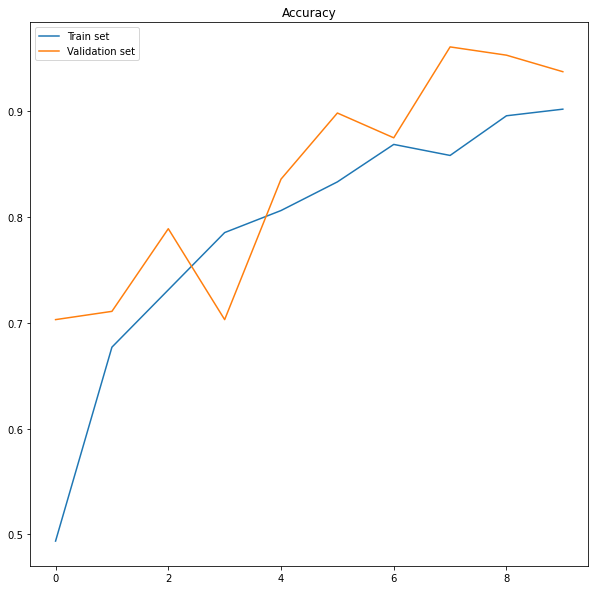

In [35]:
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(hist.history['accuracy']))
plt.plot(xaxis, hist.history['accuracy'], label='Train set')
plt.plot(xaxis, hist.history['val_accuracy'], label='Validation set')
plt.legend()

In [41]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [37]:
scores = citation_model.evaluate(val_dataset, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 91.41%


In [44]:
val_dataset

<SkipDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 4), dtype=tf.float64, name=None))>